## Flight Delay Claims Prediction – EDA

This notebook contains the source code of the exploratory data analysis (EDA) process of the Flight Delay Claims Prediction project.

### Import packages

Some common data science packages are needed to perform analysis on the data. They are imported at the beginning of the notebook.

In [1]:
import requests
from calendar import month_abbr

import numpy as np
import pandas as pd
import seaborn as sns

### Load and examine data

The CSV file is first loaded as a pandas data frame, which allows it to be read and manipulated easily. We can show the first 10 lines of the CSV file to examine the schema and some sample rows.

In [2]:
flights = pd.read_csv('../data/flight_delays_data.csv', parse_dates=['flight_date'])

In [3]:
flights.head()

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim
0,1582499,UO686,27,HKG,KIX,UO,10,0.4,2016-07-01,0
1,1582501,CI7868,17,HKG,TNN,CI,11,0.5,2015-04-23,0
2,1582504,PR301,14,HKG,MNL,PR,11,0.0,2014-04-08,0
3,1582508,LD327,37,HKG,SIN,LD,3,0.1,2013-09-15,0
4,1582509,KA5390,40,HKG,PEK,KA,9,0.5,2015-10-05,0


### Data cleaning

In [4]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899114 entries, 0 to 899113
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   flight_id    899114 non-null  int64         
 1   flight_no    899114 non-null  object        
 2   Week         899114 non-null  int64         
 3   Departure    899114 non-null  object        
 4   Arrival      899114 non-null  object        
 5   Airline      897400 non-null  object        
 6   std_hour     899114 non-null  int64         
 7   delay_time   899114 non-null  object        
 8   flight_date  899114 non-null  datetime64[ns]
 9   is_claim     899114 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 68.6+ MB


From the info output above, we can see that there are 1,714 null values in the column `Airline`, which is an issue we need to fix before proceeding. These null values can mean that their corresponding flights are special so that they don't have an associated airline, or it might simply mean that human error has occurred and they were missing by mistake.

In [5]:
flights.loc[flights.Airline.isnull()].head()

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim
773,1402,MR886,37,HKG,ULN,NaN,15,0.0,2014-09-15,0
2785,7751,AZ2689,15,HKG,CDG,NaN,22,0.4,2016-04-10,0
4568,13316,AZ5777,10,HKG,AUH,NaN,18,1.3,2016-03-09,0
5056,14873,AZ5777,21,HKG,AUH,NaN,18,0.5,2016-05-24,0
5152,15173,AZ2687,48,HKG,CDG,NaN,10,-0.1,2013-11-30,0


In [6]:
flights.loc[flights.Airline.isnull(), 'flight_id'].count()

1714

Looking at the subset of data where `Airline` is missing, we can see that these flights, in fact, do have an airline. Therefore, it appears to be an error when the dataset is recorded. From the other rows, we know that `Airline` is the IATA airline code for the flight, which is easily extractable from the `flight_no` column.

In [7]:
flights.loc[flights.Airline.isnull(), 'Airline'] = flights.loc[flights.Airline.isnull(), 'flight_no'].str[:2]

In [8]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899114 entries, 0 to 899113
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   flight_id    899114 non-null  int64         
 1   flight_no    899114 non-null  object        
 2   Week         899114 non-null  int64         
 3   Departure    899114 non-null  object        
 4   Arrival      899114 non-null  object        
 5   Airline      899114 non-null  object        
 6   std_hour     899114 non-null  int64         
 7   delay_time   899114 non-null  object        
 8   flight_date  899114 non-null  datetime64[ns]
 9   is_claim     899114 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 68.6+ MB


Now we have a more complete dataset to work on.

From the instructions of the project, we also know that `delay_time` is mostly encoded as a float value, but it could also be "Cancelled" to indicate a canceled flight. In this case, we need to figure out how we could isolate float and string values. One common way to fix this is to add a boolean column `is_cancelled` that indicates whether the flight is canceled, and set the `delay_time` to an arbitrary large number (e.g. 999) for flights that were canceled (since they are delayed _infinitely_).

Note that since we are attempting to predict the outcome of future flights, it is possible that the `delay_time` might not appear at all in the hidden dataset. Nonetheless, it is worth looking into the

In [9]:
flights['is_cancelled'] = np.where(flights.delay_time == 'Cancelled', 1, 0)

In [10]:
flights.loc[flights.delay_time == 'Cancelled', 'delay_time'] = 999
flights.delay_time = flights.delay_time.astype(float)

In [11]:
flights.groupby('is_cancelled')[['flight_id']].count()

,flight_id
is_cancelled,
0,873422
1,25692


As we can see, there are 25,692 flights that were canceled, and it might be an important indicator that would help us with the prediction down the road.

### Extra parameters and feature engineering

#### Year, month, day, and day of week

In addition to the `Week` and `flight_date` columns, we can look at the year, month, day, and day of week extracted from the `flight_date` column.

In [12]:
flights['flight_date_year'] = flights.flight_date.dt.year
flights['flight_date_month'] = flights.flight_date.dt.month
flights['flight_date_day'] = flights.flight_date.dt.day
flights['flight_date_dow'] = flights.flight_date.dt.dayofweek

In [13]:
flights.flight_date_year = flights.flight_date_year.astype('category')
flights.flight_date_month = flights.flight_date_month.astype('category')
flights.flight_date_day = flights.flight_date_day.astype('category')
flights.flight_date_dow = flights.flight_date_dow.astype('category')

#### Locale-specific data

In [14]:
list(flights.Departure.unique())

['HKG']

Since all of the flights departed from the Hong Kong International Airport, we can add external data that is related to Hong Kong.

One example would be to retrieve the public holidays data from the Hong Kong government website.

In [15]:
flight_years = flights.flight_date_year.unique()
flight_years

[2016, 2015, 2014, 2013]
Categories (4, int64): [2016, 2015, 2014, 2013]

In [16]:
public_holidays = list()

In [17]:
for year in flight_years:
    holiday_url = f'https://www.gov.hk/en/about/abouthk/holiday/{year}.htm'
    r = requests.get(holiday_url, headers={'User-Agent': 'Mozilla/5.0'})
    holiday_dates = pd.read_html(r.text, skiprows=1)[0][1].apply(lambda x: f'{x} {year}')
    holiday_dates = pd.to_datetime(holiday_dates, infer_datetime_format=True)
    public_holidays.extend(holiday_dates)

In [18]:
flights['is_public_holiday'] = np.where(flights.flight_date.isin(public_holidays), 1, 0)

In [19]:
flights.head()

,flight_id,flight_no,Week,Departure,Arrival,Airline,std_hour,delay_time,flight_date,is_claim,is_cancelled,flight_date_year,flight_date_month,flight_date_day,flight_date_dow,is_public_holiday
0,1582499,UO686,27,HKG,KIX,UO,10,0.4,2016-07-01,0,0,2016,7,1,4,1
1,1582501,CI7868,17,HKG,TNN,CI,11,0.5,2015-04-23,0,0,2015,4,23,3,0
2,1582504,PR301,14,HKG,MNL,PR,11,0.0,2014-04-08,0,0,2014,4,8,1,0
3,1582508,LD327,37,HKG,SIN,LD,3,0.1,2013-09-15,0,0,2013,9,15,6,0
4,1582509,KA5390,40,HKG,PEK,KA,9,0.5,2015-10-05,0,0,2015,10,5,0,0


#### Weather data

Since weather conditions highly influences the ability to fly, we can also look at the historic weather data published by the Hong Kong Observatory.

Specifically, Mean Pressure (hPa), Mean Air Temperature (deg. C), Mean Dew Point (deg. C), Mean Relative Humidity (%), Mean Amount of Cloud (%), and Total Rainfall (mm) were extracted.

In [20]:
weather_list = list()

In [21]:
for year in flight_years:
    weather_url = f'https://www.hko.gov.hk/cis/dailyExtract/dailyExtract_{year}'
    r = requests.get(weather_url, params={'y': year})
    weather_data = r.json()['stn']['data']

    for elem_month in weather_data:
        month = elem_month['month']
        day_data = elem_month['dayData'][:-2]
        for elem_day in day_data:
            day = elem_day[0]
            mean_pressure = float(elem_day[1])
            mean_temp = float(elem_day[3])
            mean_dew_point = float(elem_day[5])
            mean_humidity = float(elem_day[6])
            mean_cloud = float(elem_day[7])
            mean_rainfall = float(elem_day[8]) if elem_day[8] != 'Trace' else 0.0
            weather_list.append({'flight_date': pd.to_datetime(f'{year}-{month:02}-{day}'),
                                 'mean_pressure': mean_pressure, 'mean_temp': mean_temp, 'mean_dew_point': mean_dew_point,
                                 'mean_humidity': mean_humidity, 'mean_cloud': mean_cloud, 'total_rainfall': mean_rainfall})

In [22]:
weather_df = pd.DataFrame(weather_list)
flights = pd.merge(flights, weather_df, on='flight_date', how='left')

In [23]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899114 entries, 0 to 899113
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   flight_id          899114 non-null  int64         
 1   flight_no          899114 non-null  object        
 2   Week               899114 non-null  int64         
 3   Departure          899114 non-null  object        
 4   Arrival            899114 non-null  object        
 5   Airline            899114 non-null  object        
 6   std_hour           899114 non-null  int64         
 7   delay_time         899114 non-null  float64       
 8   flight_date        899114 non-null  datetime64[ns]
 9   is_claim           899114 non-null  int64         
 10  is_cancelled       899114 non-null  int64         
 11  flight_date_year   899114 non-null  category      
 12  flight_date_month  899114 non-null  category      
 13  flight_date_day    899114 non-null  category

#### Clean up

To avoid redundant information, we need to drop the original `flight_date` column. We also need to drop the `flight_id` column since it is unique that does not possess any predictive power.

In [24]:
flights = flights.drop(columns=['flight_date', 'flight_id'])

### Visualization

In [25]:
sns.set()

#### Breakdown of count by `is_claim`

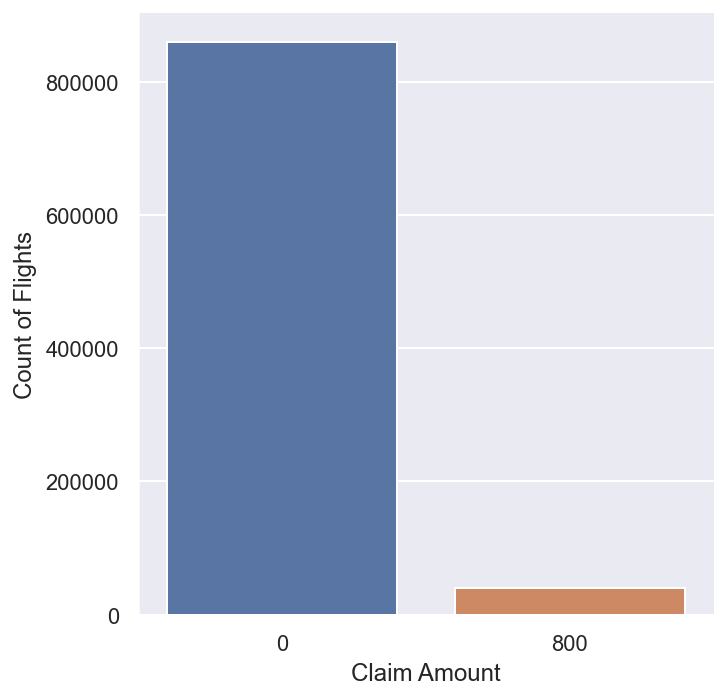

In [26]:
flight_is_claim_count = sns.catplot(x='is_claim', kind='count', data=flights) \
                           .set(xlabel='Claim Amount', ylabel='Count of Flights')

From the bar plot above, we can see that there are significantly less \\$800 claims than \\$0, which means that the issue of imbalance dataset exists. Therefore, upsampling may be required in order to achieved high accuracy. However, given that `is_claim` is a logically generated column derived from `delay_time` and the fact that `delay_time` might not exist in the hidden dataset, we can predict `delay_time` instead and use it to compute `is_claim`.

#### Breakdown of count by `flight_date_month`

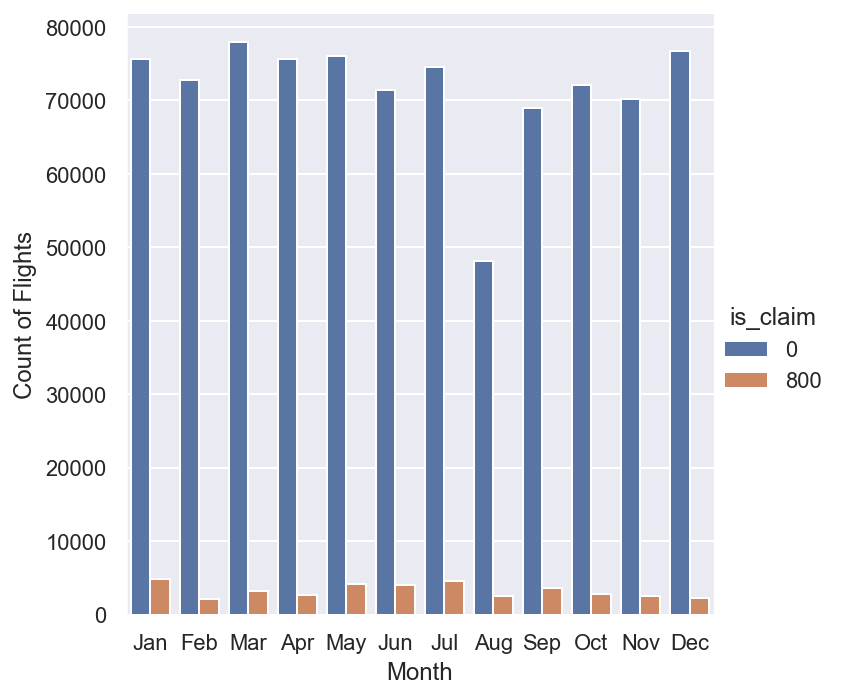

In [27]:
flight_month_count = sns.catplot(x='flight_date_month', hue='is_claim', kind='count', data=flights) \
                        .set(xlabel='Month', ylabel='Count of Flights') \
                        .set_xticklabels(month_abbr[1:])

From the bar plot above, we can see that the flight counts across months are roughly equal except for August where there is significantly less data.

#### Trend of `delay_time` by year and month

In order to accurately examine the effect of `delay_time`, all canceled flights will be filtered out in the following visualizations.

In [28]:
non_canceled_flights = flights.loc[flights.is_cancelled == 0]

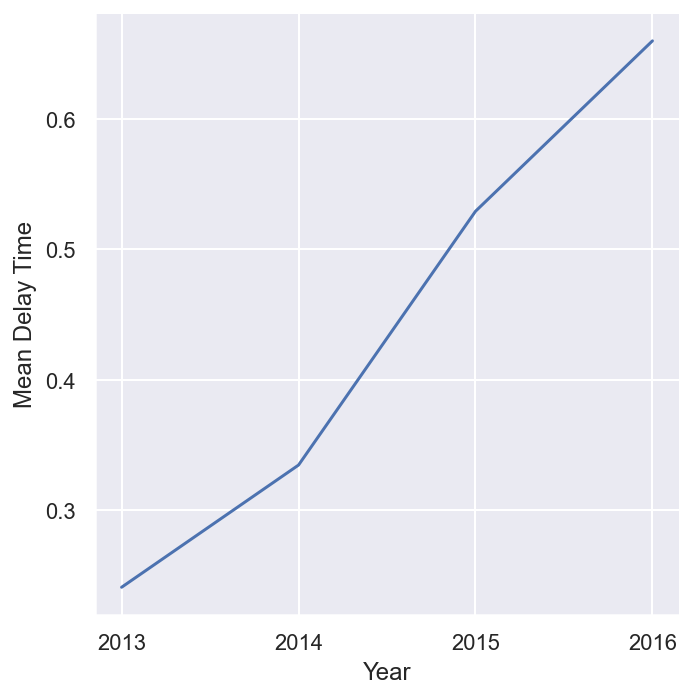

In [29]:
flight_year_delay = non_canceled_flights.groupby('flight_date_year').mean()[['delay_time']].reset_index()
flight_year_delay_plot = sns.relplot(x='flight_date_year', y='delay_time', kind='line', data=flight_year_delay) \
                            .set(xlabel='Year', ylabel='Mean Delay Time') \
                            .ax.set_xticks(flight_year_delay.flight_date_year)

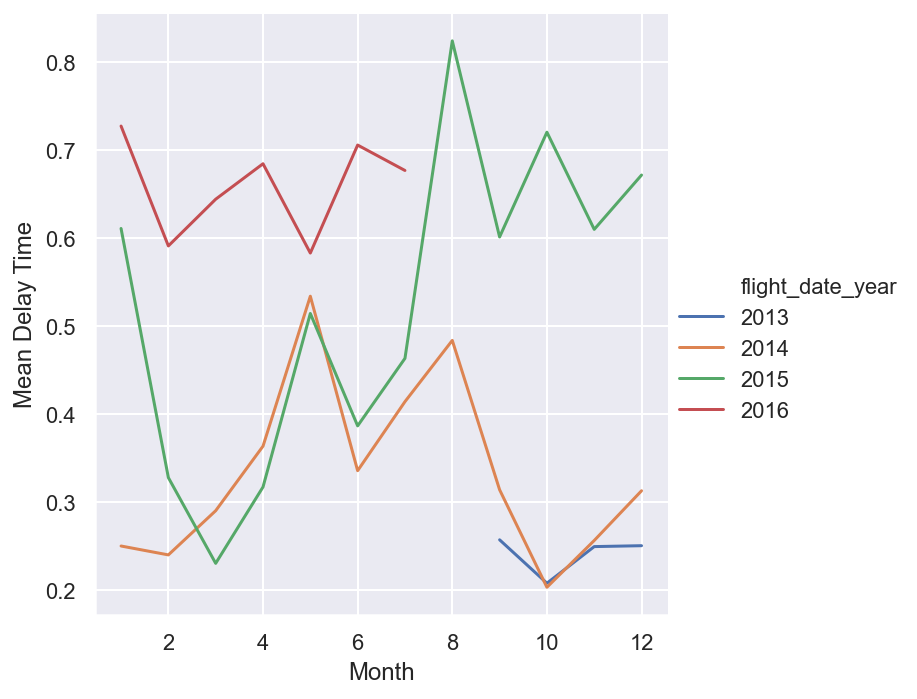

In [30]:
flight_month_delay = non_canceled_flights.groupby(['flight_date_year', 'flight_date_month']).mean()[['delay_time']].reset_index()
flight_month_delay_plot = sns.relplot(x='flight_date_month', y='delay_time', hue='flight_date_year', kind='line', data=flight_month_delay) \
                             .set(xlabel='Month', ylabel='Mean Delay Time')

Looking at the two plots above, we can see that as time progressed, there is a positive increase in average `delay_time`, which means `flight_date_year` could be a strong indicator that influences `delay_time` and ultimately `is_claim`.

#### Airline with the least and most delay

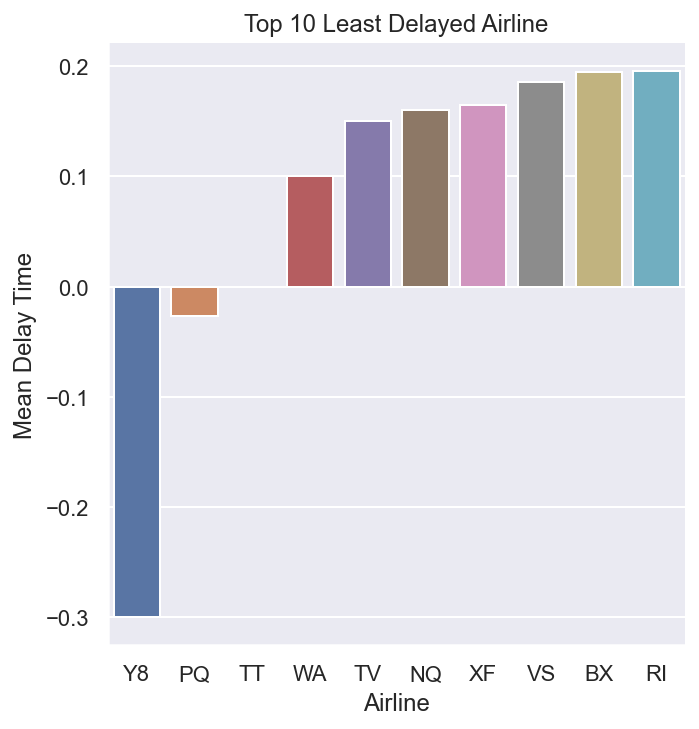

In [31]:
flight_airline_delay = non_canceled_flights.groupby('Airline').mean()[['delay_time']].reset_index().sort_values('delay_time')
flight_airline_least_delay_plot = sns.catplot(x='Airline', y='delay_time', kind='bar', data=flight_airline_delay.head(10)) \
                                     .set(title='Top 10 Least Delayed Airline', ylabel='Mean Delay Time')

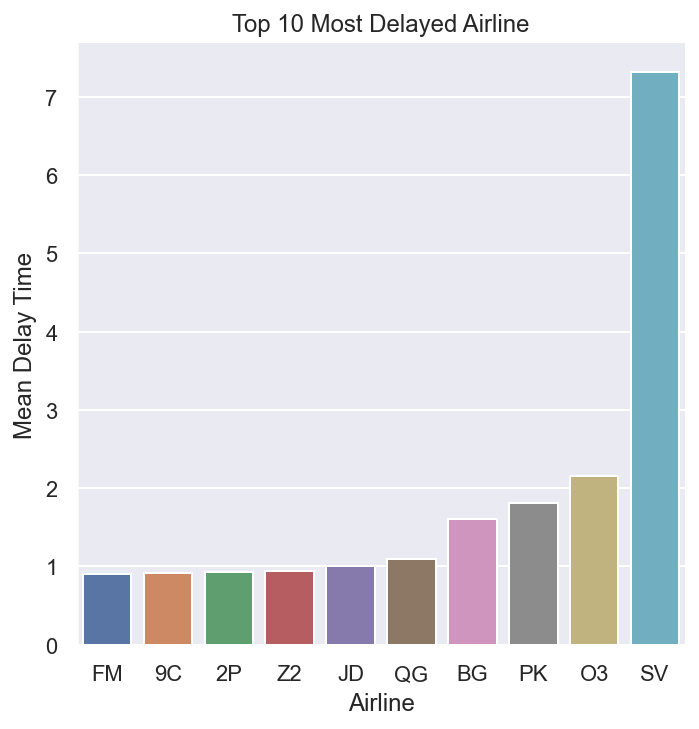

In [32]:
flight_airline_most_delay_plot = sns.catplot(x='Airline', y='delay_time', kind='bar', data=flight_airline_delay.tail(10)) \
                                    .set(title='Top 10 Most Delayed Airline', ylabel='Mean Delay Time')

Looking at the two bar plots above, it is likely that some airlines are more prone to delays than others.

#### Relationship between weather and delay

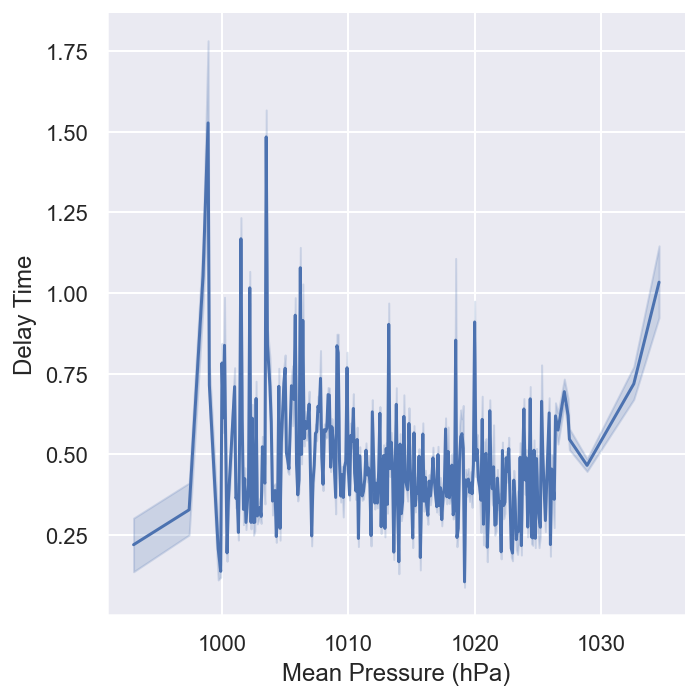

In [33]:
flights_weather_pressure_plot = sns.relplot(x='mean_pressure', y='delay_time', kind='line', data=non_canceled_flights) \
                                   .set(xlabel='Mean Pressure (hPa)', ylabel='Delay Time')

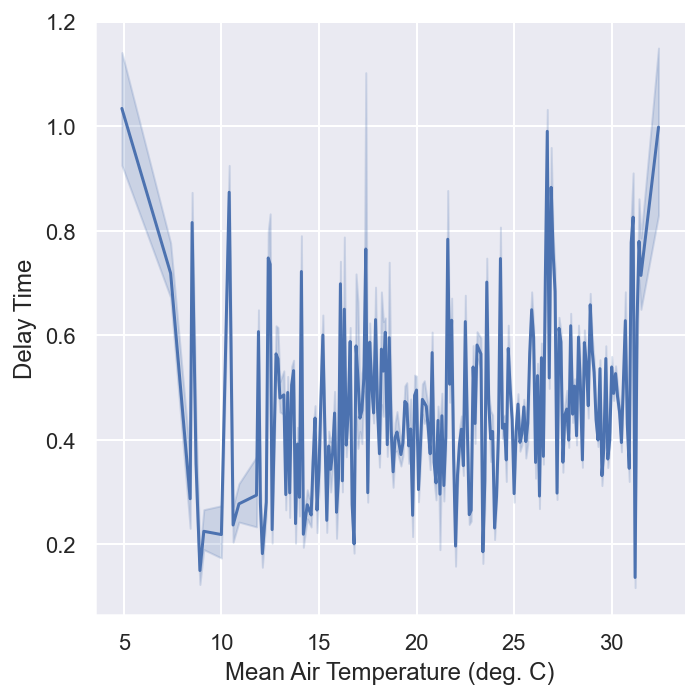

In [34]:
flights_weather_temp_plot = sns.relplot(x='mean_temp', y='delay_time', kind='line', data=non_canceled_flights) \
                               .set(xlabel='Mean Air Temperature (deg. C)', ylabel='Delay Time')

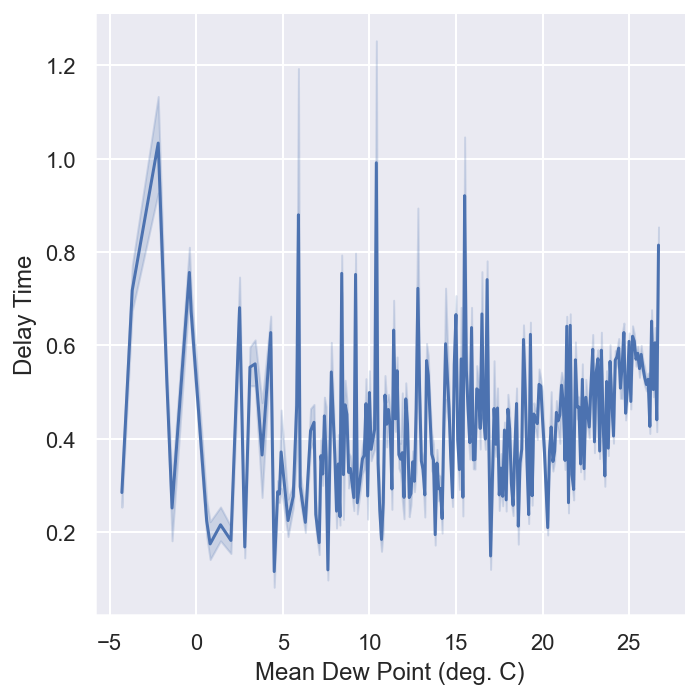

In [35]:
flights_weather_dew_point_plot = sns.relplot(x='mean_dew_point', y='delay_time', kind='line', data=non_canceled_flights) \
                                    .set(xlabel='Mean Dew Point (deg. C)', ylabel='Delay Time')

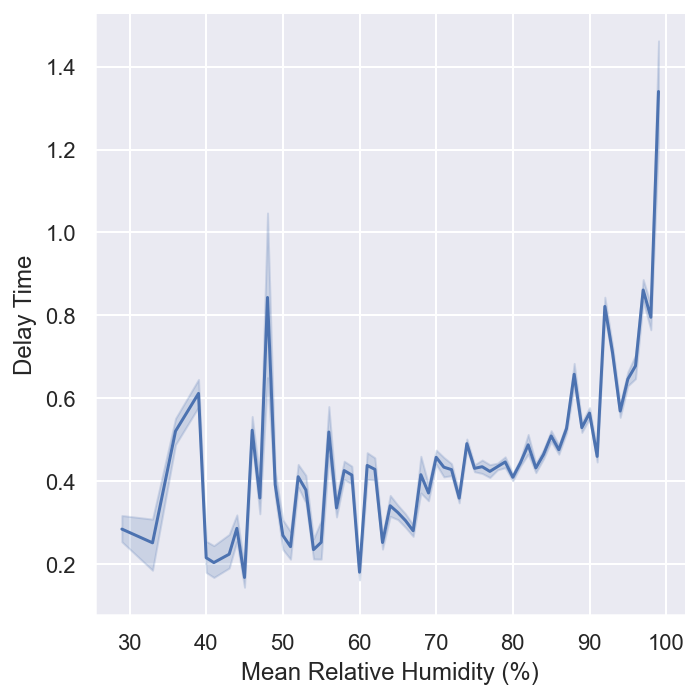

In [36]:
flights_weather_humidity_plot = sns.relplot(x='mean_humidity', y='delay_time', kind='line', data=non_canceled_flights) \
                                   .set(xlabel='Mean Relative Humidity (%)', ylabel='Delay Time')

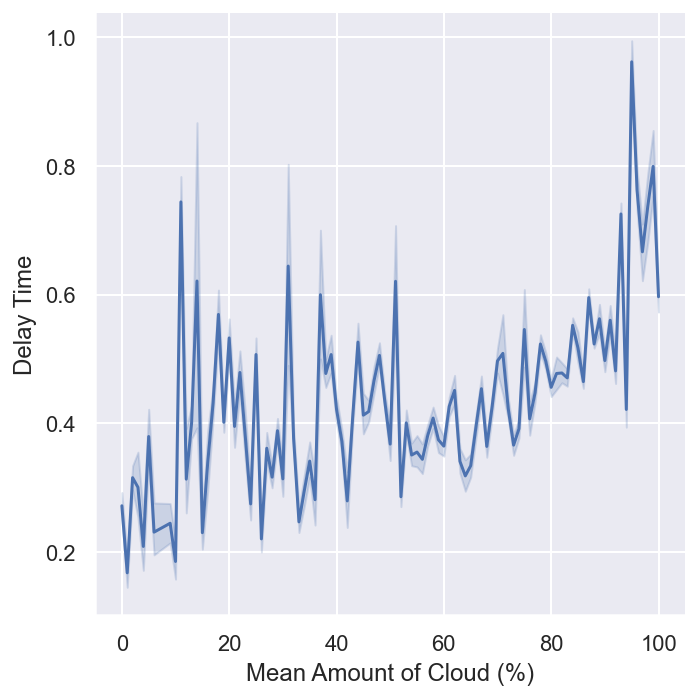

In [37]:
flights_weather_cloud_plot = sns.relplot(x='mean_cloud', y='delay_time', kind='line', data=non_canceled_flights) \
                                .set(xlabel='Mean Amount of Cloud (%)', ylabel='Delay Time')

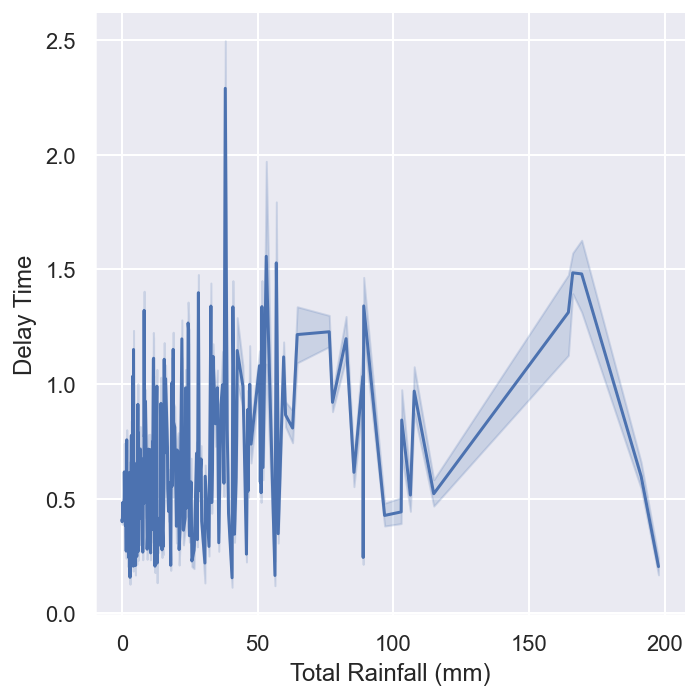

In [38]:
flights_weather_rainfall_plot = sns.relplot(x='total_rainfall', y='delay_time', kind='line', data=non_canceled_flights) \
                                   .set(xlabel='Total Rainfall (mm)', ylabel='Delay Time')

Looking at the line plots above, it seems like `mean_humidity` and `mean_cloud` have a higher positive linear relationship with `delay_time`, whereas other weather attributes are less reflective. However, since these plots only shows non-canceled flights, it is possible that more extreme weather conditions have rendered the flights canceled.

#### Relationship between public holidays and delay time

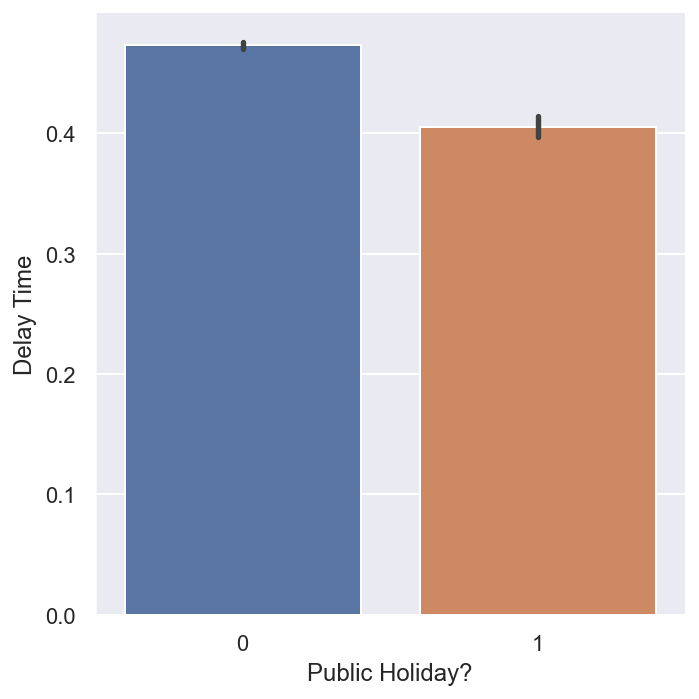

In [39]:
flights_holiday_plot = sns.catplot(x='is_public_holiday', y='delay_time', kind='bar', data=non_canceled_flights) \
                          .set(xlabel='Public Holiday?', ylabel='Delay Time')

Looking at the bar plot, it seems like `is_public_holiday` does not have a significant effect on `delay_time`. Hence, it might not be an influential feature.

#### Relationship between `std_hour` and `is_claim`

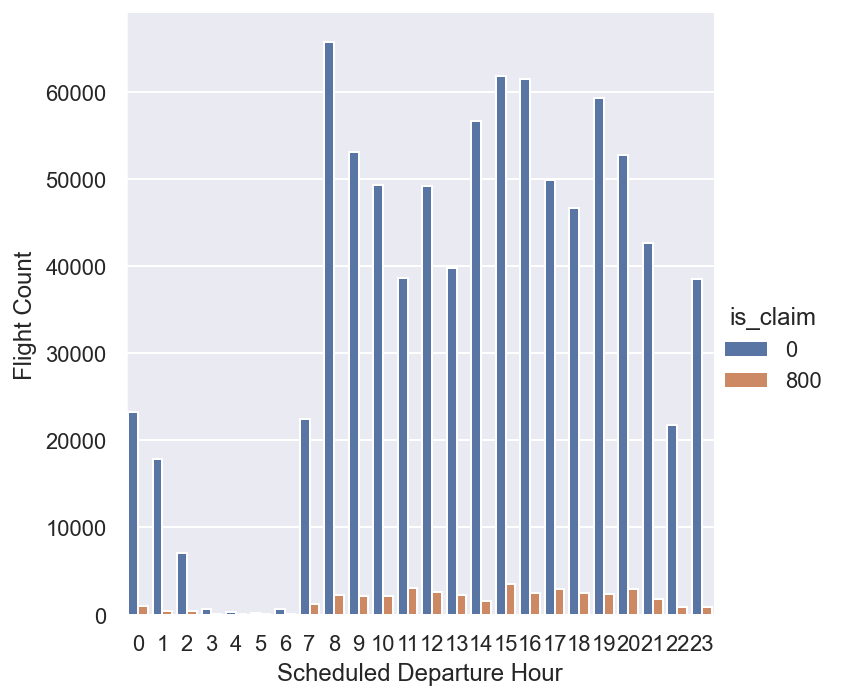

In [40]:
flight_hours_count_plot = sns.catplot(x='std_hour', hue='is_claim', kind='count', data=flights) \
                             .set(xlabel='Scheduled Departure Hour', ylabel='Flight Count')

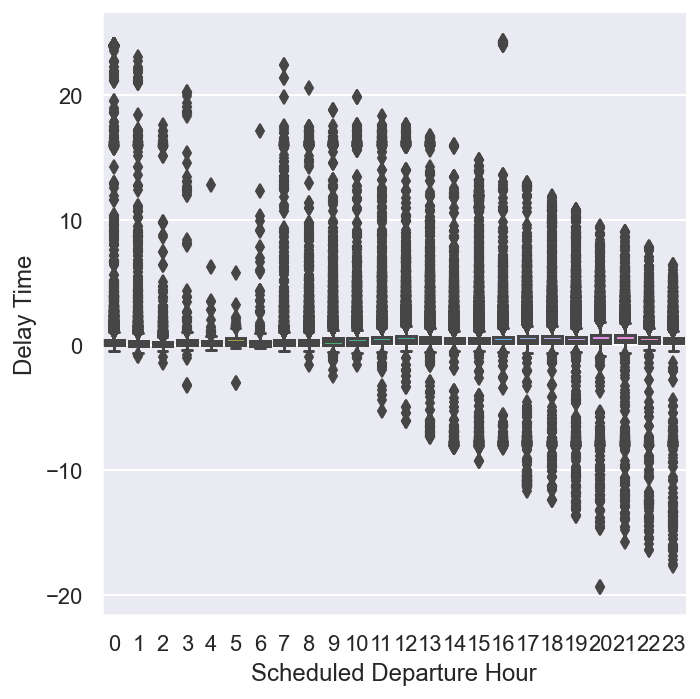

In [41]:
flights_hours_delay_plot = sns.catplot(x='std_hour', y='delay_time', kind='box', data=non_canceled_flights) \
                              .set(xlabel='Scheduled Departure Hour', ylabel='Delay Time')

From the two plots above, we can see that, on average, the median delay time is roughly the same throughout the day. Meanwhile, the ranges in the delay time for flights in the afternoon seemed to be lower than those in the morning.

#### Relationship between flight routes and delay time

In [42]:
flights_routes = non_canceled_flights.groupby('flight_no').mean()[['delay_time']].sort_values(by='delay_time').reset_index()

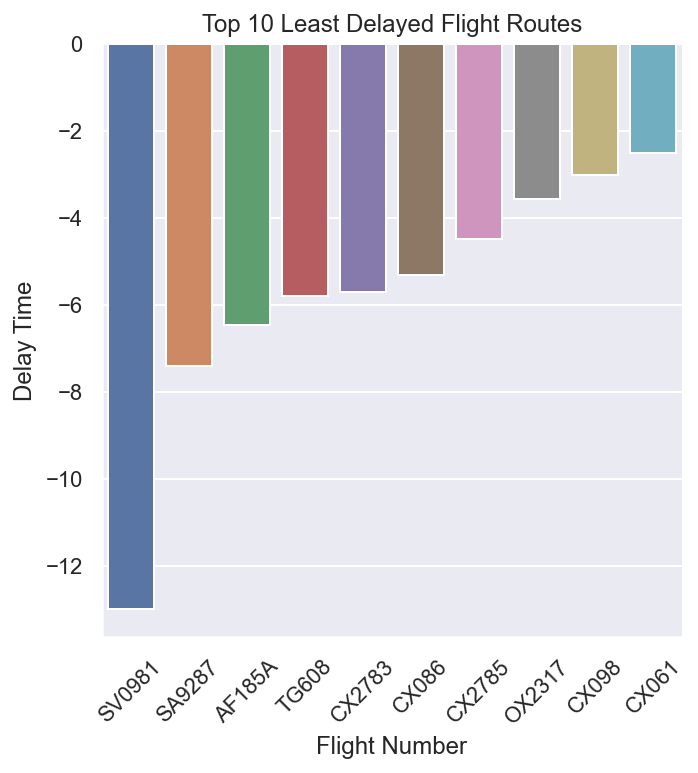

In [43]:
flights_routes_least_delay_plot = sns.catplot(x='flight_no', y='delay_time', kind='bar', data=flights_routes.head(10)) \
                                     .set(title='Top 10 Least Delayed Flight Routes', xlabel='Flight Number', ylabel='Delay Time') \
                                     .set_xticklabels(rotation=45)

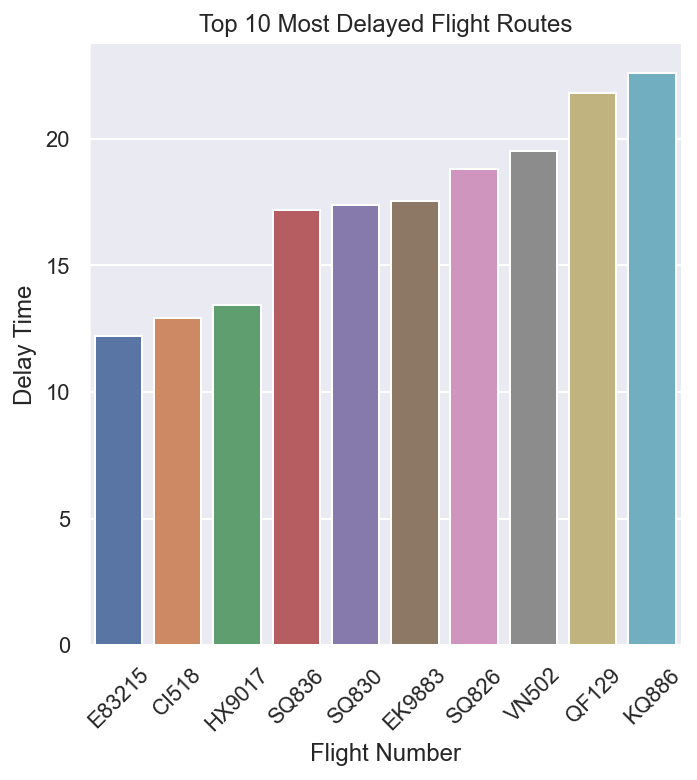

In [44]:
flights_routes_most_delay_plot = sns.catplot(x='flight_no', y='delay_time', kind='bar', data=flights_routes.tail(10)) \
                                    .set(title='Top 10 Most Delayed Flight Routes', xlabel='Flight Number', ylabel='Delay Time') \
                                    .set_xticklabels(rotation=45)

Looking at the two plots above, it seems to be true that some routes are more prone to delays that others. This might be important during the modeling process.